In [ ]:
! apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 ghostscript libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x libavalon-framework-

In [ ]:
pip install SciencePlots

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scienceplots
import os
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
plt.style.use(['science'])

## Confidence analysis

In [ ]:
def load_metrics(base_path):
    metrics = {}

    confidence_matrices = {
        "bos": {},
        "source": {},
        "target": {},
        "sentence": {}
    }

    coverage_matrices = {
        "bos": {},
        "source": {},
        "target": {},
        "sentence": {}
    }

    src = ['spa_Latn', 'eng_Latn', 'fra_Latn', 'ita_Latn', 'cat_Latn', 'por_Latn', 'deu_Latn', 'eus_Latn', 'glg_Latn']
    tgt = ['spa_Latn', 'eng_Latn', 'fra_Latn', 'ita_Latn', 'cat_Latn', 'por_Latn', 'deu_Latn', 'eus_Latn', 'glg_Latn']
    language_directions = [f'{s}-{t}' for s in src for t in tgt if s != t]

    for ld in language_directions:
        paths = {
            "confidence": {
                "bos": os.path.join(base_path, ld, 'confidence_bos.npy'),
                "source": os.path.join(base_path, ld, 'confidence_source.npy'),
                "target": os.path.join(base_path, ld, 'confidence_target.npy'),
                "sentence": os.path.join(base_path, ld, 'confidence_sentence.npy')
            },
            "coverage": {
                "bos": os.path.join(base_path, ld, 'coverage_bos.npy'),
                "source": os.path.join(base_path, ld, 'coverage_source.npy'),
                "target": os.path.join(base_path, ld, 'coverage_target.npy'),
                "sentence": os.path.join(base_path, ld, 'coverage_sentence.npy')
            }
        }

        # Load matrices if all required files exist
        if all(os.path.exists(path) for path in paths["confidence"].values()):
            for key in confidence_matrices.keys():
                confidence_matrices[key][ld] = np.load(paths["confidence"][key])
                coverage_matrices[key][ld] = np.load(paths["coverage"][key])
        else:
            print(f"Files for {ld} not found. Skipping...")

    metrics['confidence'] = confidence_matrices
    metrics['coverage'] = coverage_matrices

    return metrics

# Usage
base_path256 = '/content/drive/MyDrive/attention_results/checkpoint-540000_gemma256_distributed'
metrics_256 = load_metrics(base_path256)

base_path128 = '/content/drive/MyDrive/attention_results/checkpoint-570000_gemma128_distributed'
metrics_128 = load_metrics(base_path128)

base_path32 = '/content/drive/MyDrive/attention_results/checkpoint-645000_gemma32_distributed'
metrics_32 = load_metrics(base_path32)

In [ ]:
keys = ['bos', 'source', 'sentence', 'target']
categories = ['confidence', 'coverage']

for category in categories:
    for key in keys:
        values = [v for _, v in metrics_256[category][key].items()]
        metrics_256[category][key]['avg'] = np.mean(values, axis=0)

        values = [v for _, v in metrics_128[category][key].items()]
        metrics_128[category][key]['avg'] = np.mean(values, axis=0)

        values = [v for _, v in metrics_32[category][key].items()]
        metrics_32[category][key]['avg'] = np.mean(values, axis=0)

## Plots

In [ ]:
# Create a subplot figure
# Function to plot data in each subplot
C_MAP = 'coolwarm'
def plot_matrix(ax, lang_direction, confidence_matrices, where='Sentence', metric='Confidence',
                ax_visible='off', x_axis=False, y_axis=False, vmin=None, vmax=None, show_colorbar=True):
    if lang_direction:
        if vmin is None and vmax is None:
          im = ax.imshow(confidence_matrices[lang_direction], cmap=C_MAP)
        else:
          im = ax.imshow(confidence_matrices[lang_direction], cmap=C_MAP, vmin=vmin, vmax=vmax)
        ax.set_title(f'{where}', size=SIZE_TITLE)
        ax.axis(ax_visible)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=5.5)  # Set major tick label size
        ax.tick_params(axis='both', which='minor', width=0)
        ax.yaxis.set_ticks_position('left')  # Position y-axis ticks only on the left
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('Head', fontsize=11)
        ax.set_ylabel('Layer', fontsize=11)

        if not y_axis:
          ax.tick_params(axis='y', which='both', left=False, labelleft=False)
          ax.set_ylabel('', fontsize=0)

        if show_colorbar:
          divider = make_axes_locatable(ax)
          cax = divider.append_axes("right", size="5%", pad=0.5)
          plt.colorbar(im, cax=cax, orientation='vertical', ax=ax)

          cax.tick_params(axis='x', which='major')  # Customize tick appearance as needed
          for spine in cax.spines.values():
              spine.set_visible(False)

        return im
    ax.set_visible(False)
    return None

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_metric_data(metrics, key, ld, name_colorbar, vmin, vmax, colormap='coolwarm', save_path=None):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))

    plot_labels = ['bos', 'source', 'sentence', 'target', 'Colorbar']
    plot_labels_dict = {'bos':'BOS', 'source':'Source tag', 'sentence': 'Source sentence', 'target':'Target tag'}
    visibility = [True, True, True, True, False]

    for i in range(4):  # Loop to handle the first four subplots
        data = metrics[key][plot_labels[i].lower()]
        im = plot_matrix(axes[i], ld, data, plot_labels_dict[plot_labels[i]], key.capitalize(), 'on',
                         True, i == 0, vmin=vmin, vmax=vmax, show_colorbar=False)

    # Handle the colorbar in the last subplot
    axes[4].set_visible(False)
    divider = make_axes_locatable(axes[4])
    colorbar = plt.colorbar(im, cax=None, location='left', orientation='vertical', pad=0.5, shrink=0.73, ax=axes[4], label=name_colorbar)

    for spine in colorbar.ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()

In [ ]:
coverage_bos256 = np.mean(np.mean([v for c, v in metrics_256['coverage']['bos'].items()], axis = 0), axis=1 )
coverage_bos128 = np.mean(np.mean([v for c, v in metrics_128['coverage']['bos'].items()], axis = 0), axis=1 )
coverage_bos32 = np.mean(np.mean([v for c, v in metrics_32['coverage']['bos'].items()], axis = 0), axis=1 )

coverage_source256 = np.mean(np.mean([v for c, v in metrics_256['coverage']['source'].items()], axis = 0), axis=1 )
coverage_source128 = np.mean(np.mean([v for c, v in metrics_128['coverage']['source'].items()], axis = 0), axis=1 )
coverage_source32 = np.mean(np.mean([v for c, v in metrics_32['coverage']['source'].items()], axis = 0), axis=1 )

coverage_sentence256 = np.mean(np.mean([v for c, v in metrics_256['coverage']['sentence'].items()], axis = 0), axis=1 )
coverage_sentence128 = np.mean(np.mean([v for c, v in metrics_128['coverage']['sentence'].items()], axis = 0), axis=1 )
coverage_sentence32 = np.mean(np.mean([v for c, v in metrics_32['coverage']['sentence'].items()], axis = 0), axis=1 )

coverage_target256 = np.mean(np.mean([v for c, v in metrics_256['coverage']['target'].items()], axis = 0), axis=1 )
coverage_target128 = np.mean(np.mean([v for c, v in metrics_128['coverage']['target'].items()], axis = 0), axis=1 )
coverage_target32 = np.mean(np.mean([v for c, v in metrics_32['coverage']['target'].items()], axis = 0), axis=1 )

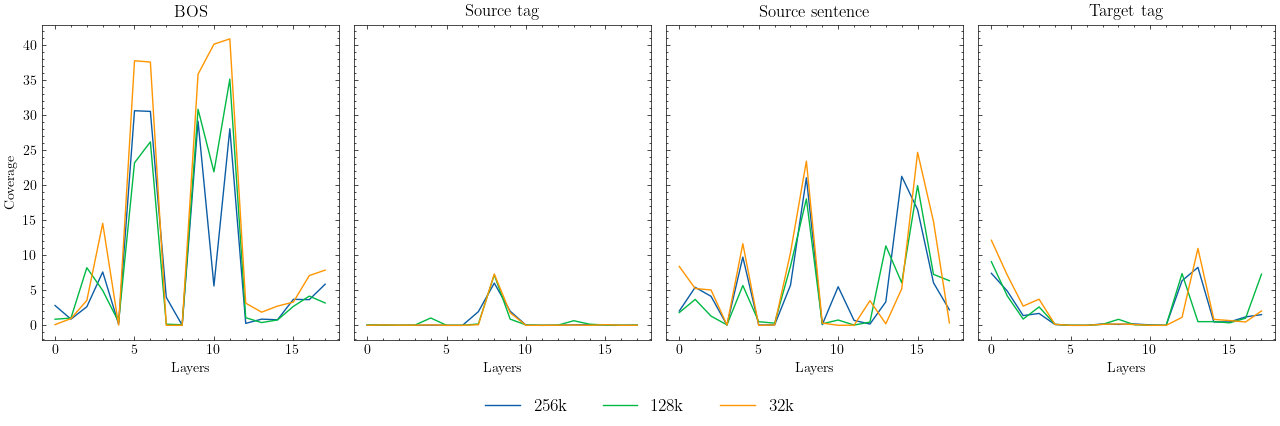

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 4), sharey=True)

# Plot for 'bos'
ax1.plot(list(range(18)), coverage_bos256, label='256k')
ax1.plot(list(range(18)), coverage_bos128, label='128k')
ax1.plot(list(range(18)), coverage_bos32, label='32k')
ax1.set_title('BOS')
ax1.set_xlabel('Layers')
ax1.set_ylabel('Coverage')
#ax1.legend()

# Plot for 'source'
ax2.plot(list(range(18)), coverage_source256, label='256k')
ax2.plot(list(range(18)), coverage_source128, label='128k')
ax2.plot(list(range(18)), coverage_source32, label='32k')
ax2.set_title('Source tag')
ax2.set_xlabel('Layers')
#ax2.legend()

ax3.plot(list(range(18)), coverage_sentence256, label='256k')
ax3.plot(list(range(18)), coverage_sentence128, label='128k')
ax3.plot(list(range(18)), coverage_sentence32, label='32k')
ax3.set_title('Source sentence')
ax3.set_xlabel('Layers')

ax4.plot(list(range(18)), coverage_target256, label='256k')
ax4.plot(list(range(18)), coverage_target128, label='128k')
ax4.plot(list(range(18)), coverage_target32, label='32k')
ax4.set_title('Target tag')
ax4.set_xlabel('Layers')

# Display the plots

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
handles4, labels4 = ax4.get_legend_handles_labels()

handles = handles1
labels = labels1

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12.5, markerscale=3.9)

plt.tight_layout()
plt.savefig('comparison_prompt_vocab_size.pdf', dpi=400)
plt.show()

In [ ]:
( coverage_source32.mean() + coverage_source128.mean() + coverage_source256.mean() )/3

0.5620151659567908

In [ ]:
( coverage_bos32.mean() + coverage_bos128.mean() + coverage_bos256.mean() )/3

10.366710939283816

In [ ]:
( coverage_target32.mean() + coverage_target128.mean() + coverage_target256.mean() )/3

2.076249186172413

In [ ]:
( coverage_sentence32.mean() + coverage_sentence128.mean() + coverage_sentence256.mean() )/3

5.736460045602406

In [ ]:
C_MAP = 'coolwarm'
SIZE_TITLE = 10
FIG_SIZE_WIDTH = 10
FIG_SIZE_HEIGHT_PER_ROW = 3.5

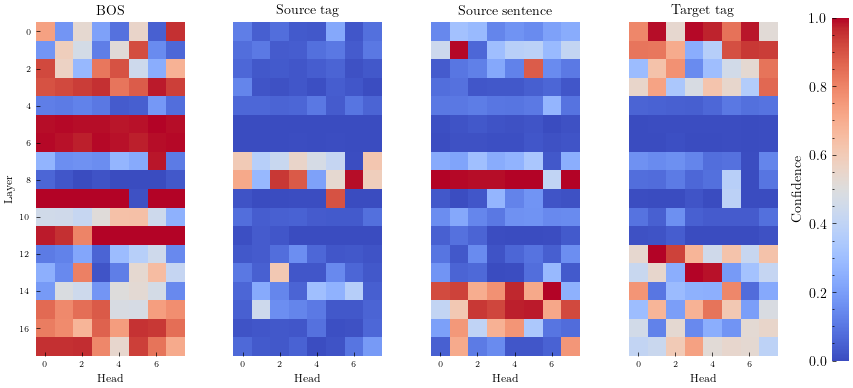

In [ ]:
plot_metric_data(metrics_256, 'confidence', 'avg', 'Confidence', 0, 1, save_path='confidence_avg_source_target_sentence256.png')

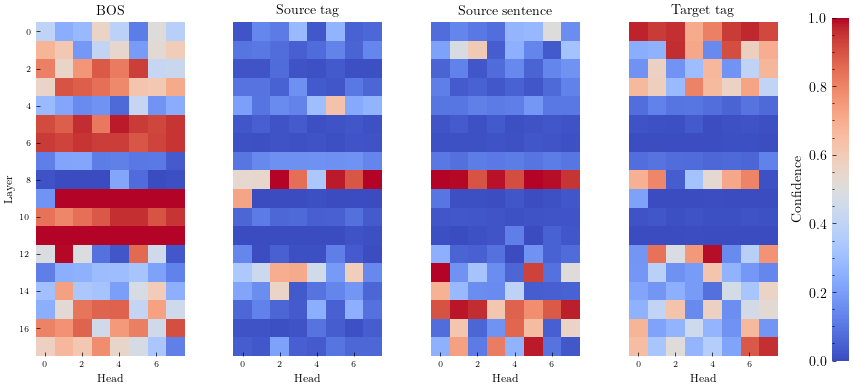

In [ ]:
plot_metric_data(metrics_128, 'confidence', 'avg', 'Confidence', 0, 1, save_path='confidence_avg_source_target_sentence128.png')

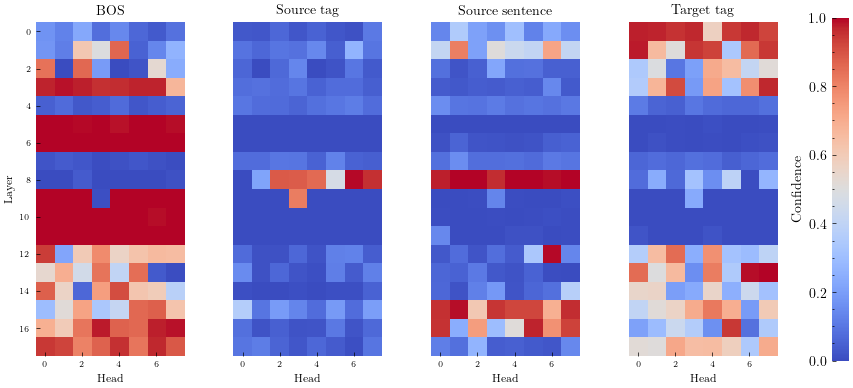

In [ ]:
plot_metric_data(metrics_32, 'confidence', 'avg', 'Confidence', 0, 1, save_path='confidence_avg_source_target_sentence32.png')

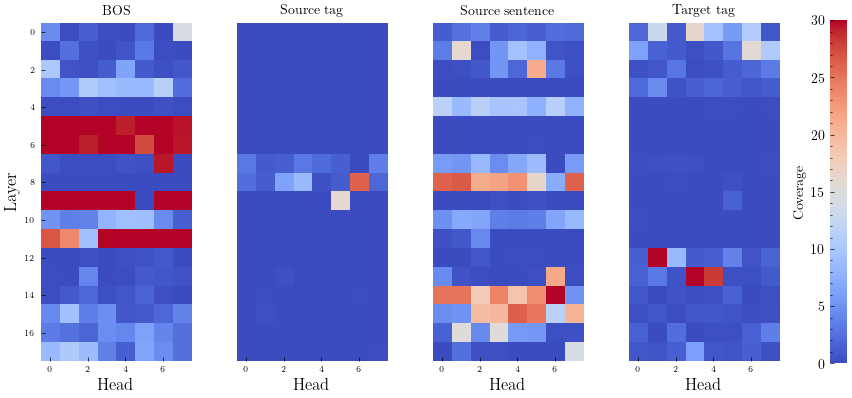

In [ ]:
plot_metric_data(metrics_256, 'coverage', 'avg', 'Coverage', 0, 30, save_path='coverage_avg_source_target_sentence256.pdf')

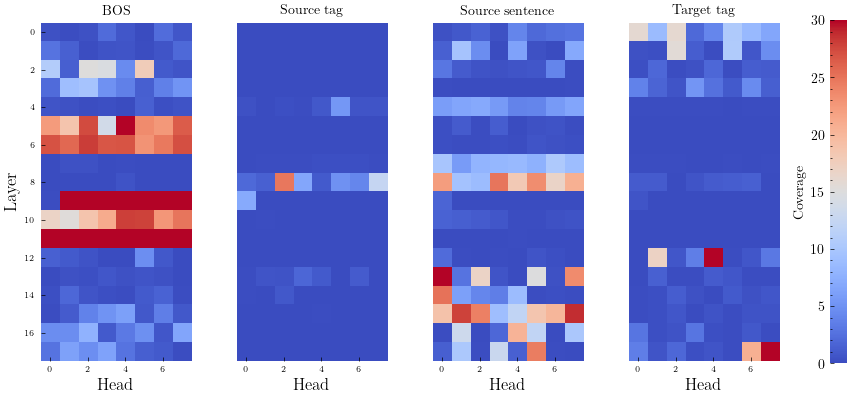

In [ ]:
plot_metric_data(metrics_128, 'coverage', 'avg', 'Coverage', 0, 30, save_path='coverage_avg_source_target_sentence128.pdf')

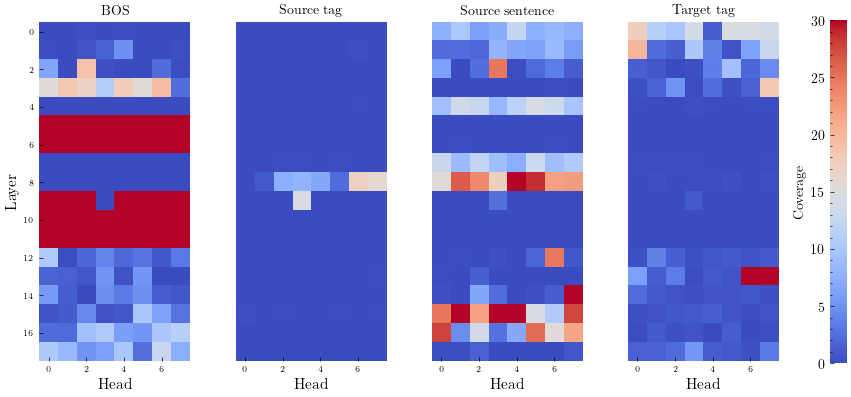

In [ ]:
plot_metric_data(metrics_32, 'coverage', 'avg', 'Coverage', 0, 30, save_path='coverage_avg_source_target_sentence32.png')

### Per MT directions

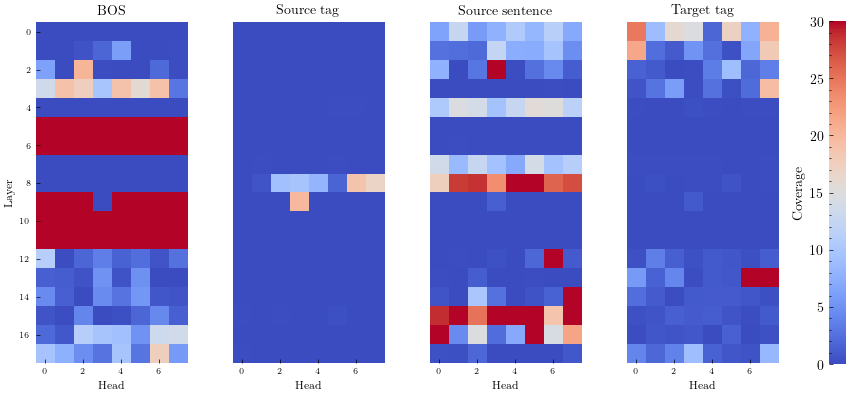

In [ ]:
plot_metric_data(metrics_32, 'coverage', 'spa_Latn-cat_Latn', 'Coverage', 0, 30, save_path='coverage_spa_Latn_cat_Latn_source_target_sentence32.png')

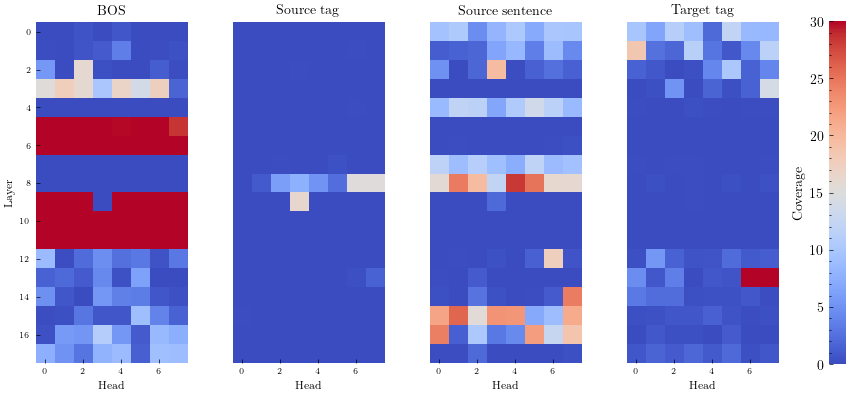

In [ ]:
plot_metric_data(metrics_32, 'coverage', 'deu_Latn-eus_Latn', 'Coverage', 0, 30, save_path='coverage_deu_Latn_eus_Latn_source_target_sentence32.png')

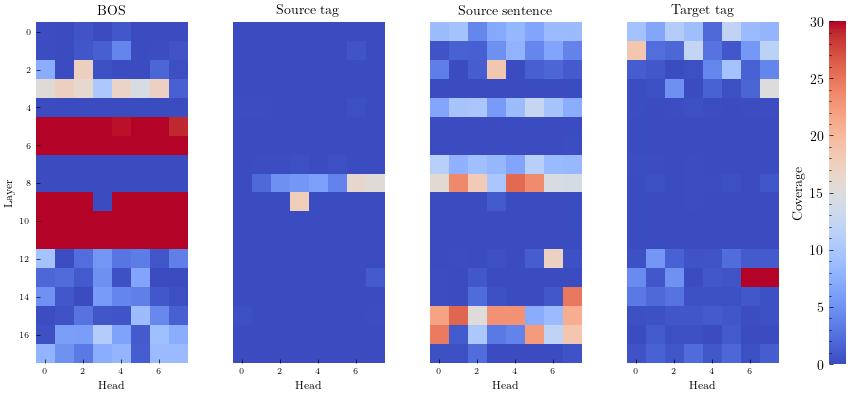

In [ ]:
plot_metric_data(metrics_32, 'coverage', 'eng_Latn-eus_Latn', 'Coverage', 0, 30, save_path='coverage_eng_Latn_eus_Latn_source_target_sentence32.png')

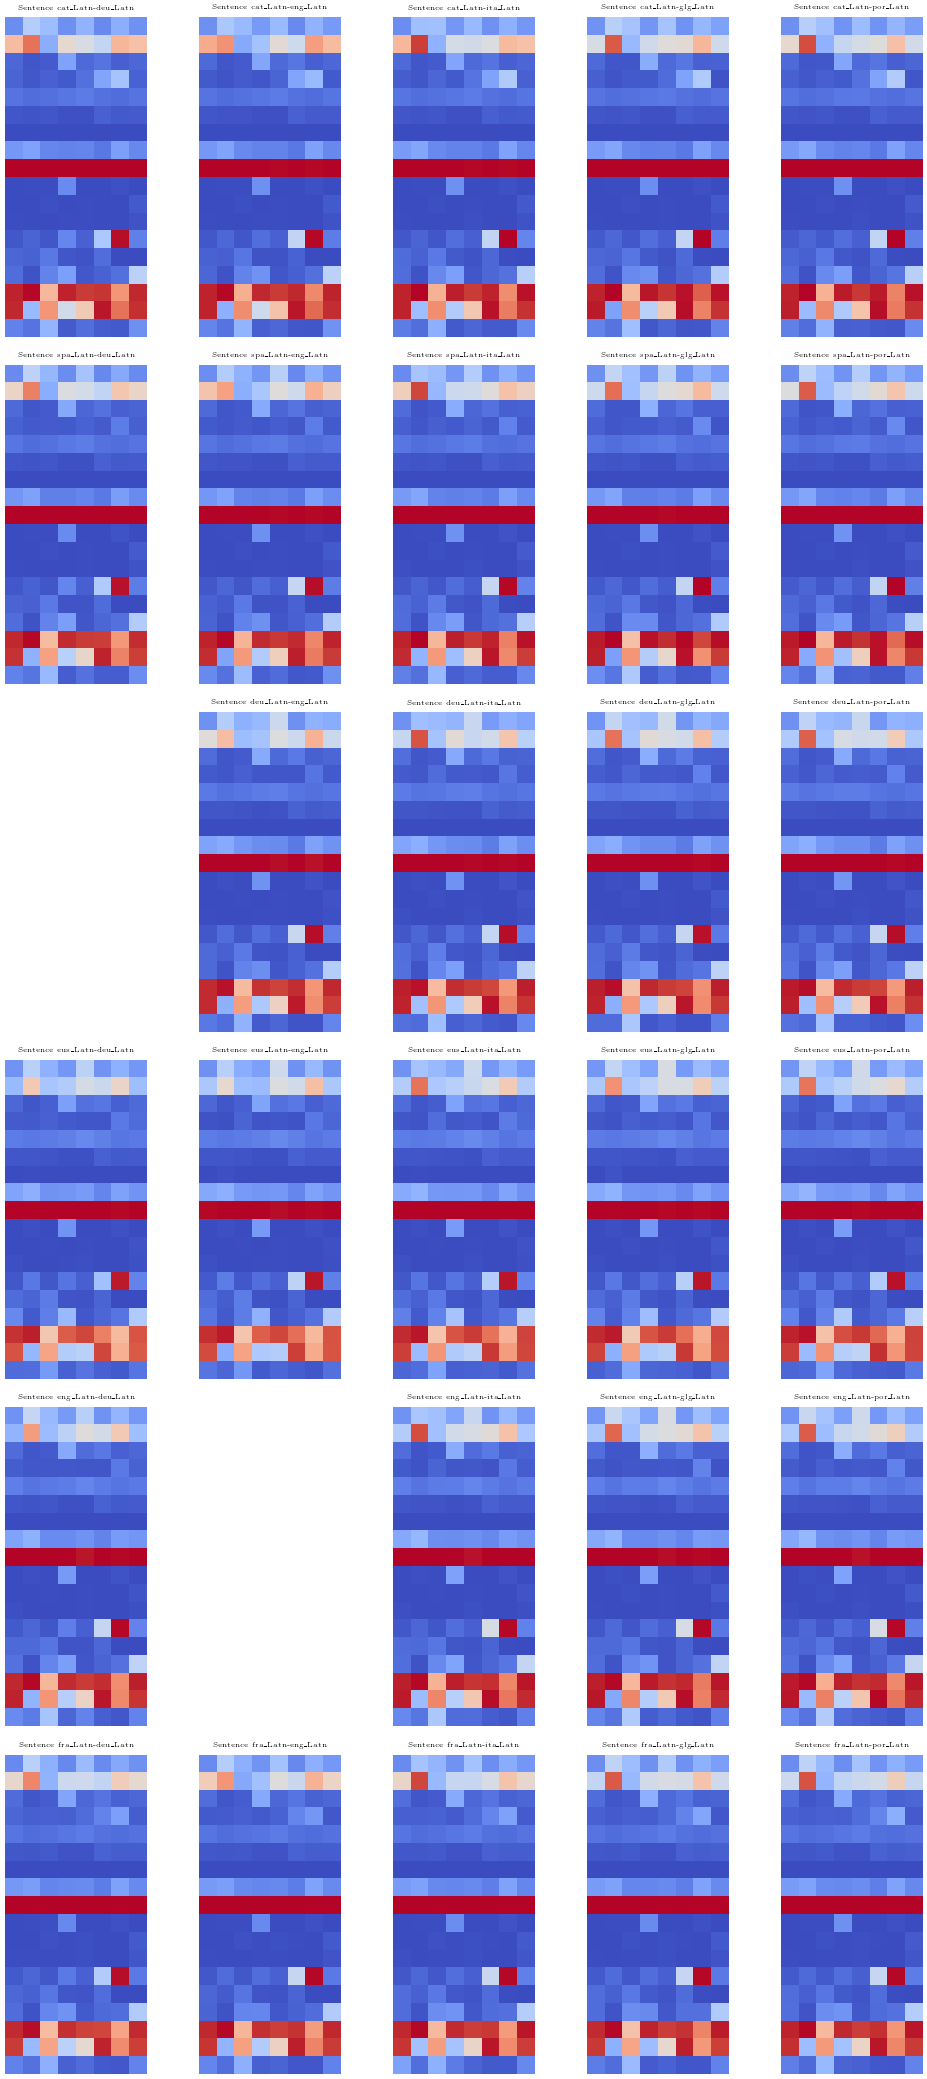

In [ ]:
# Configuration constants
C_MAP = 'coolwarm'
SIZE_TITLE = 5
FIG_SIZE_WIDTH = 10
FIG_SIZE_HEIGHT_PER_ROW = 3.5

# Language directions for plot
language_directions_plot = [
    ('cat_Latn-deu_Latn', 'cat_Latn-eng_Latn', 'cat_Latn-ita_Latn', 'cat_Latn-glg_Latn', 'cat_Latn-por_Latn'),
    ('spa_Latn-deu_Latn', 'spa_Latn-eng_Latn', 'spa_Latn-ita_Latn', 'spa_Latn-glg_Latn', 'spa_Latn-por_Latn'),
    ('', 'deu_Latn-eng_Latn', 'deu_Latn-ita_Latn', 'deu_Latn-glg_Latn', 'deu_Latn-por_Latn'),
    ('eus_Latn-deu_Latn', 'eus_Latn-eng_Latn', 'eus_Latn-ita_Latn', 'eus_Latn-glg_Latn', 'eus_Latn-por_Latn'),
    ('eng_Latn-deu_Latn', '', 'eng_Latn-ita_Latn', 'eng_Latn-glg_Latn', 'eng_Latn-por_Latn'),
    ('fra_Latn-deu_Latn', 'fra_Latn-eng_Latn', 'fra_Latn-ita_Latn', 'fra_Latn-glg_Latn', 'fra_Latn-por_Latn'),
]

# Iterate through the data and plot
fig, axes = plt.subplots(nrows=len(language_directions_plot), ncols=len(language_directions_plot[0]), figsize=(FIG_SIZE_WIDTH, FIG_SIZE_HEIGHT_PER_ROW * len(language_directions_plot)))
cax_list = []
for i, lang_directions in enumerate(language_directions_plot):
    for j, lang_direction in enumerate(lang_directions):
        cax = plot_matrix(axes[i, j], lang_direction, confidence_matrices_sentence, f'Sentence {lang_direction}', vmin=0, vmax=1, show_colorbar=False)
        if cax:
            cax_list.append(cax)

# Optional: Add a colorbar if needed
#if cax_list:
#    fig.colorbar(cax_list[-1], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02)

plt.tight_layout()
plt.savefig('confidence_sentence.png', dpi=300)
plt.show()

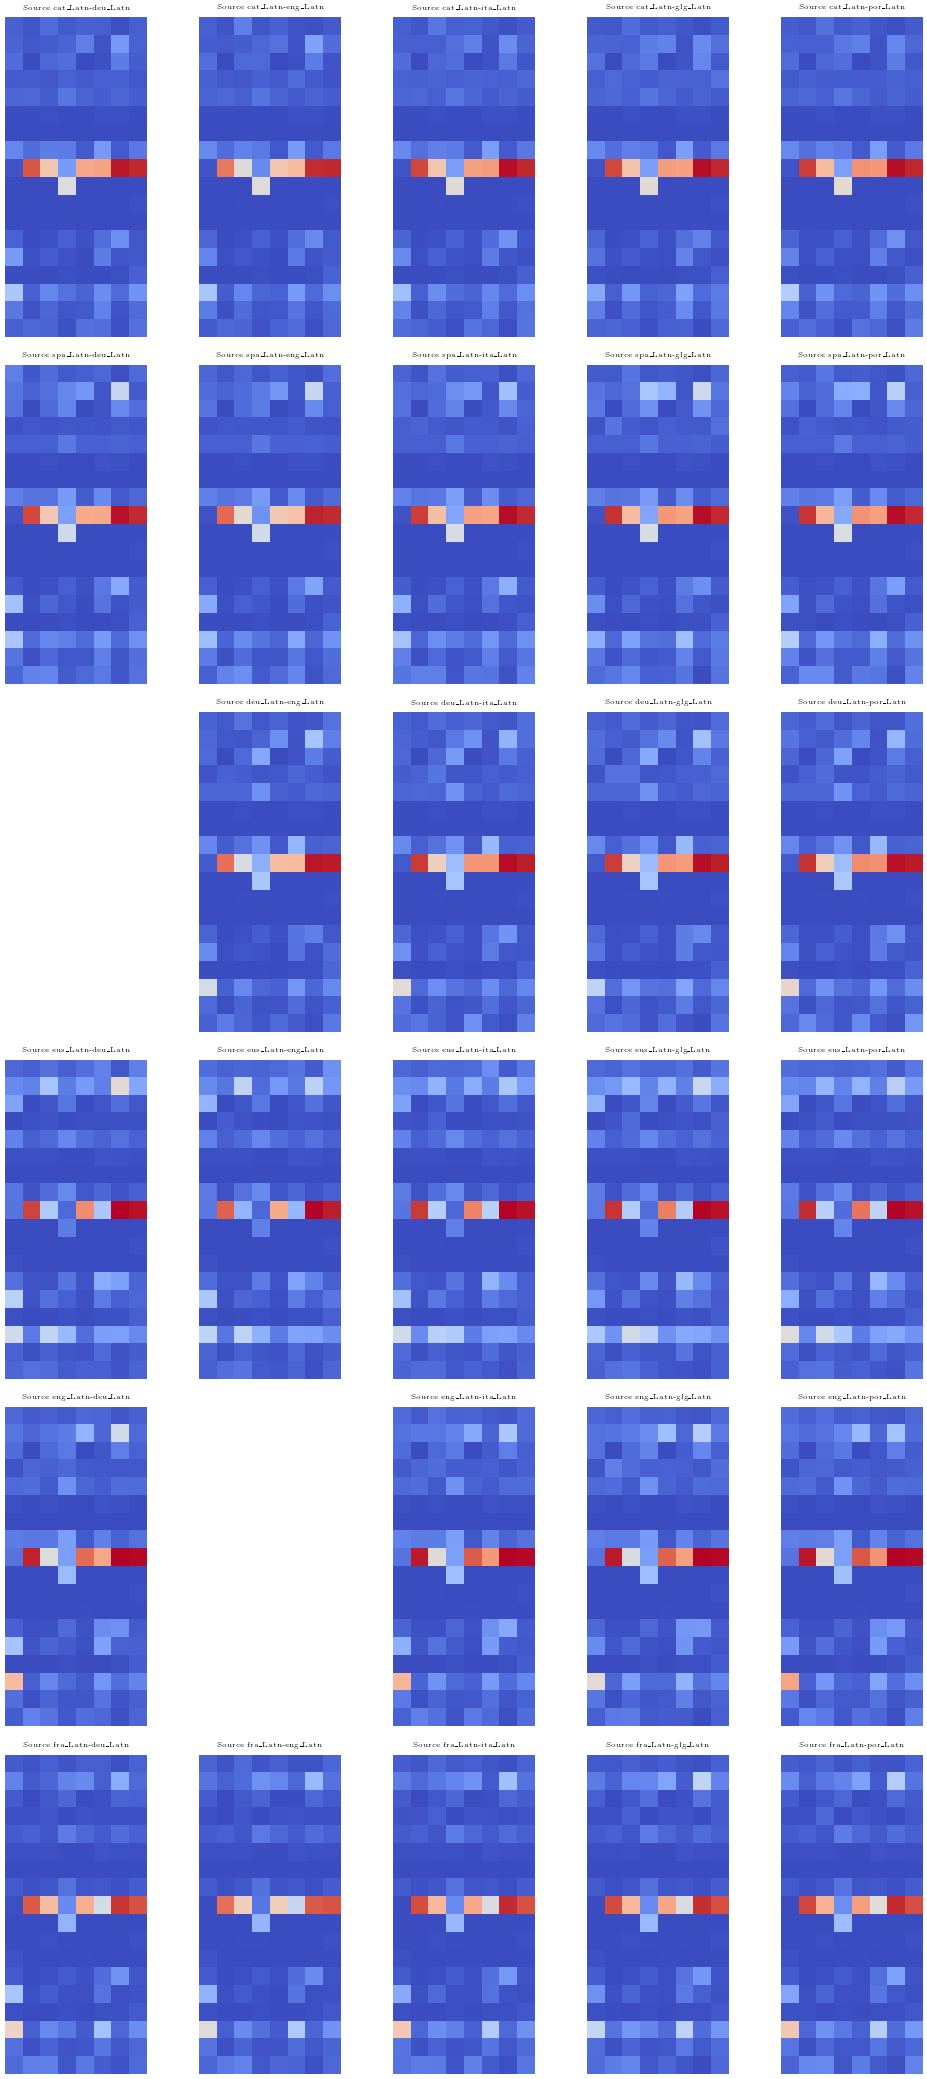

In [ ]:
fig, axes = plt.subplots(nrows=len(language_directions_plot), ncols=len(language_directions_plot[0]), figsize=(FIG_SIZE_WIDTH, FIG_SIZE_HEIGHT_PER_ROW * len(language_directions_plot)))
cax_list = []
for i, lang_directions in enumerate(language_directions_plot):
    for j, lang_direction in enumerate(lang_directions):
        cax = plot_matrix(axes[i, j], lang_direction, confidence_matrices_source, f'Source {lang_direction}', vmin=0, vmax=1, show_colorbar=False)
        if cax:
            cax_list.append(cax)

# Optional: Add a colorbar if needed
#if cax_list:
#    fig.colorbar(cax_list[-1], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02)

plt.tight_layout()
plt.savefig('confidence_source.png', dpi=540)
plt.show()

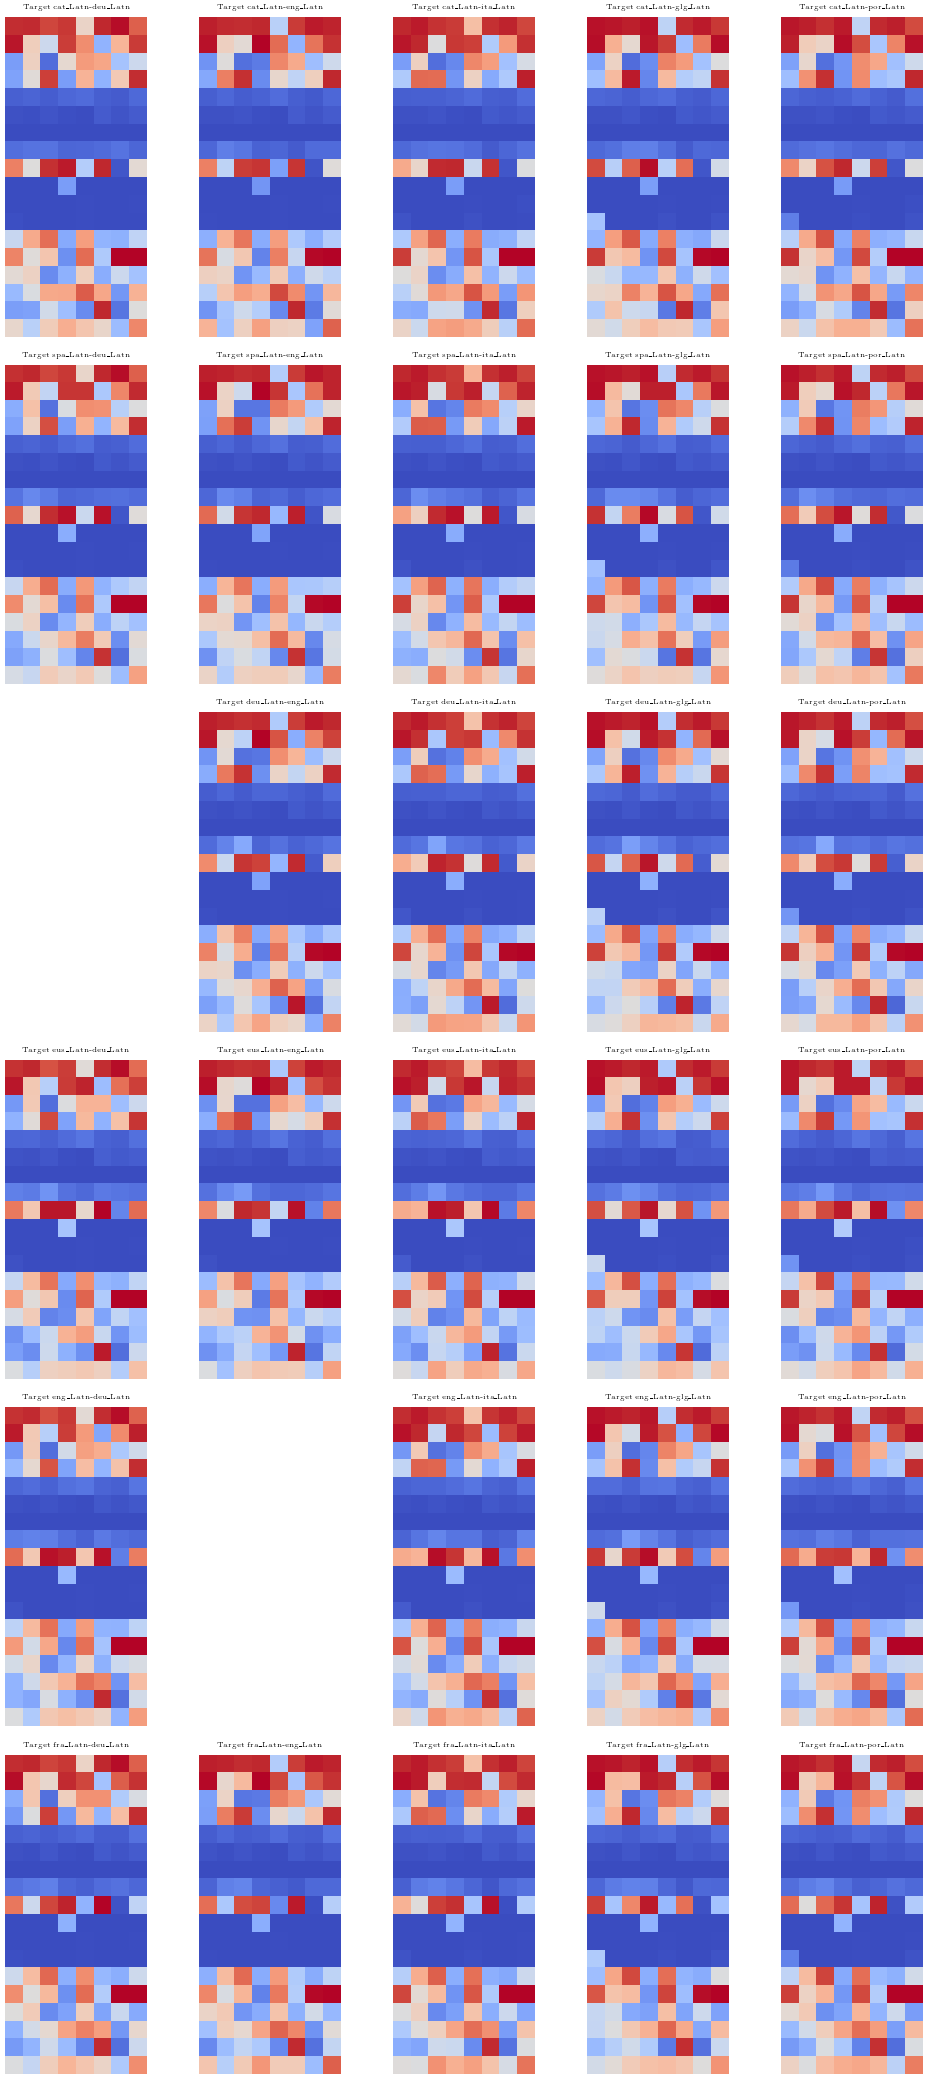

In [ ]:
fig, axes = plt.subplots(nrows=len(language_directions_plot), ncols=len(language_directions_plot[0]), figsize=(FIG_SIZE_WIDTH, FIG_SIZE_HEIGHT_PER_ROW * len(language_directions_plot)))
cax_list = []
for i, lang_directions in enumerate(language_directions_plot):
    for j, lang_direction in enumerate(lang_directions):
        cax = plot_matrix(axes[i, j], lang_direction, confidence_matrices_target, f'Target {lang_direction}', vmin=0, vmax=1, show_colorbar=False)
        if cax:
            cax_list.append(cax)

# Optional: Add a colorbar if needed
#if cax_list:
#    fig.colorbar(cax_list[-1], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02)

plt.tight_layout()
plt.savefig('confidence_target.png', dpi=300)
plt.show()

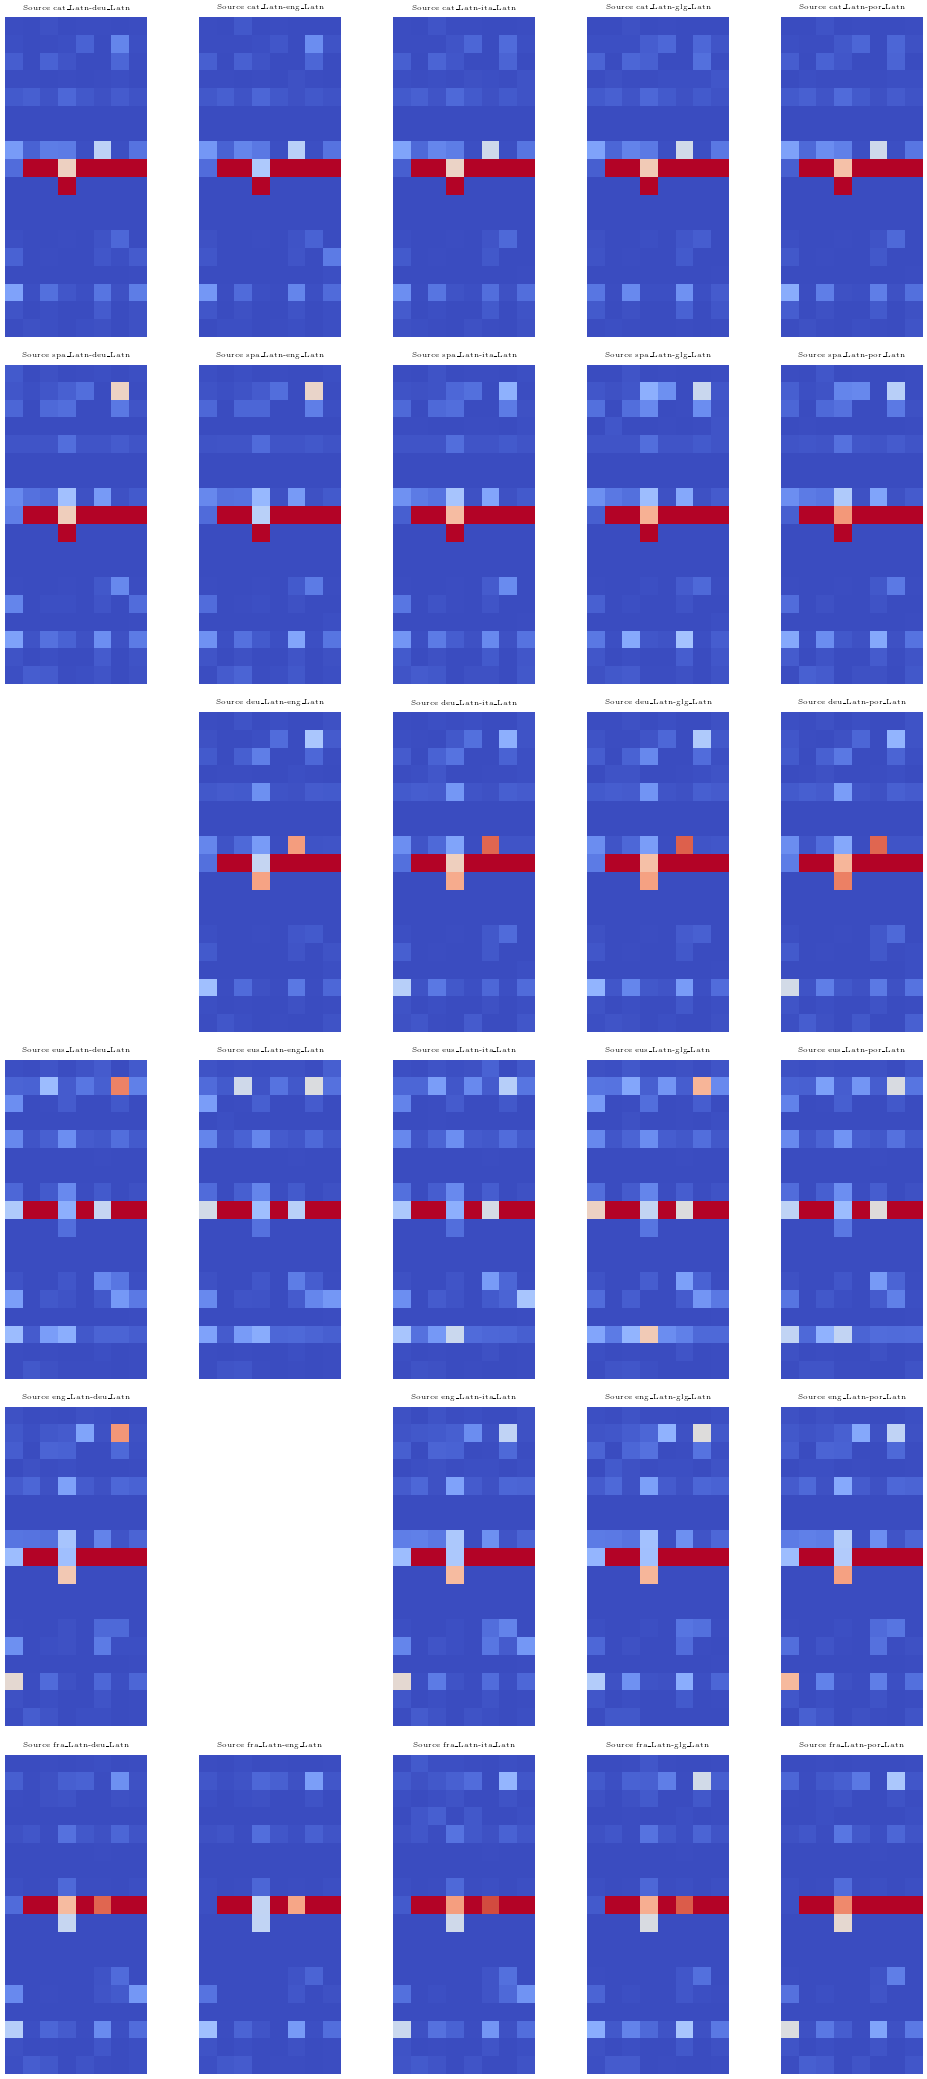

In [ ]:
fig, axes = plt.subplots(nrows=len(language_directions_plot), ncols=len(language_directions_plot[0]), figsize=(FIG_SIZE_WIDTH, FIG_SIZE_HEIGHT_PER_ROW * len(language_directions_plot)))
cax_list = []
for i, lang_directions in enumerate(language_directions_plot):
    for j, lang_direction in enumerate(lang_directions):
        cax = plot_matrix(axes[i, j], lang_direction, coverage_matrices_source, f'Source {lang_direction}', vmin=0, vmax=1, show_colorbar=False)
        if cax:
            cax_list.append(cax)

# Optional: Add a colorbar if needed
#if cax_list:
#    fig.colorbar(cax_list[-1], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02)

plt.tight_layout()
plt.savefig('coverage_source.png', dpi=540)
plt.show()

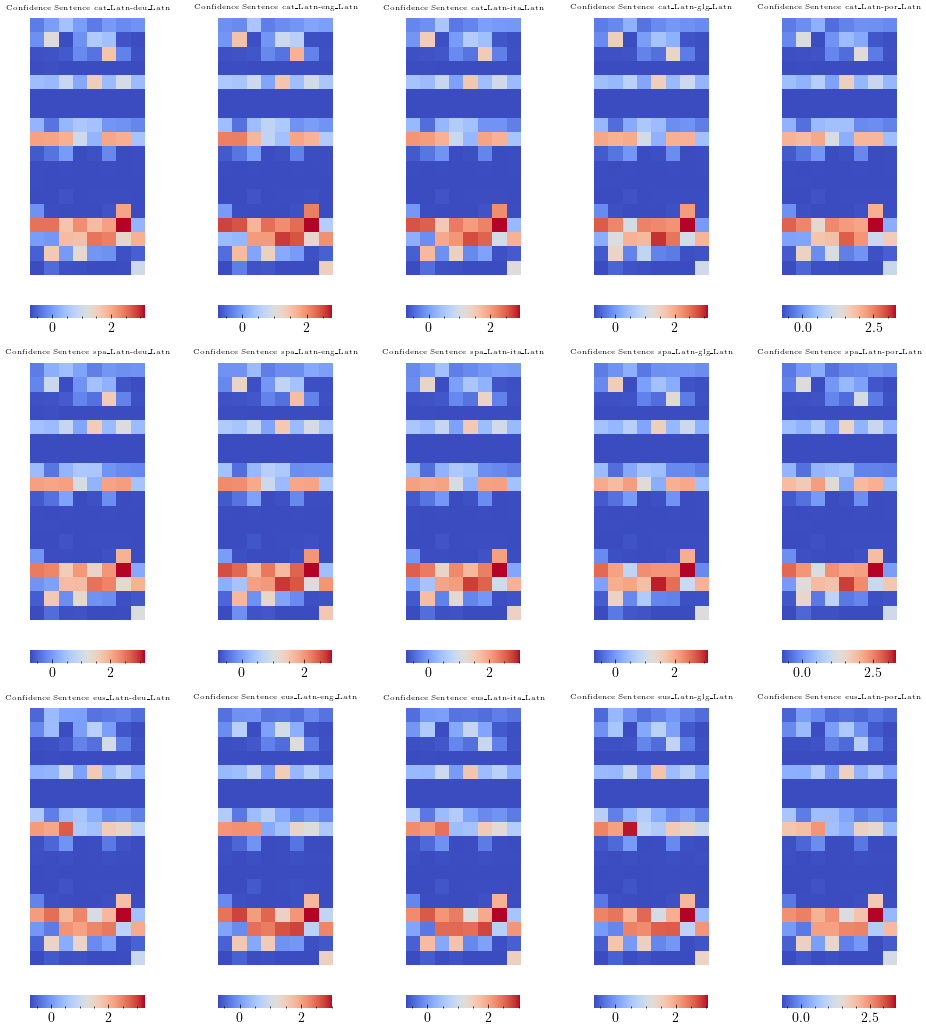

In [ ]:
# Iterate through the data and plot
fig, axes = plt.subplots(nrows=len(language_directions_plot), ncols=len(language_directions_plot[0]), figsize=(FIG_SIZE_WIDTH, FIG_SIZE_HEIGHT_PER_ROW * len(language_directions_plot)))
cax_list = []
for i, lang_directions in enumerate(language_directions_plot):
    for j, lang_direction in enumerate(lang_directions):
        cax = plot_matrix(axes[i, j], lang_direction, coverage_matrices_sentence, f'Sentence {lang_direction}')
        if cax:
            cax_list.append(cax)

# Optional: Add a colorbar if needed
#if cax_list:
#    fig.colorbar(cax_list[-1], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02)

plt.tight_layout()
plt.savefig('coverage_sentence.png', dpi=300)
plt.show()

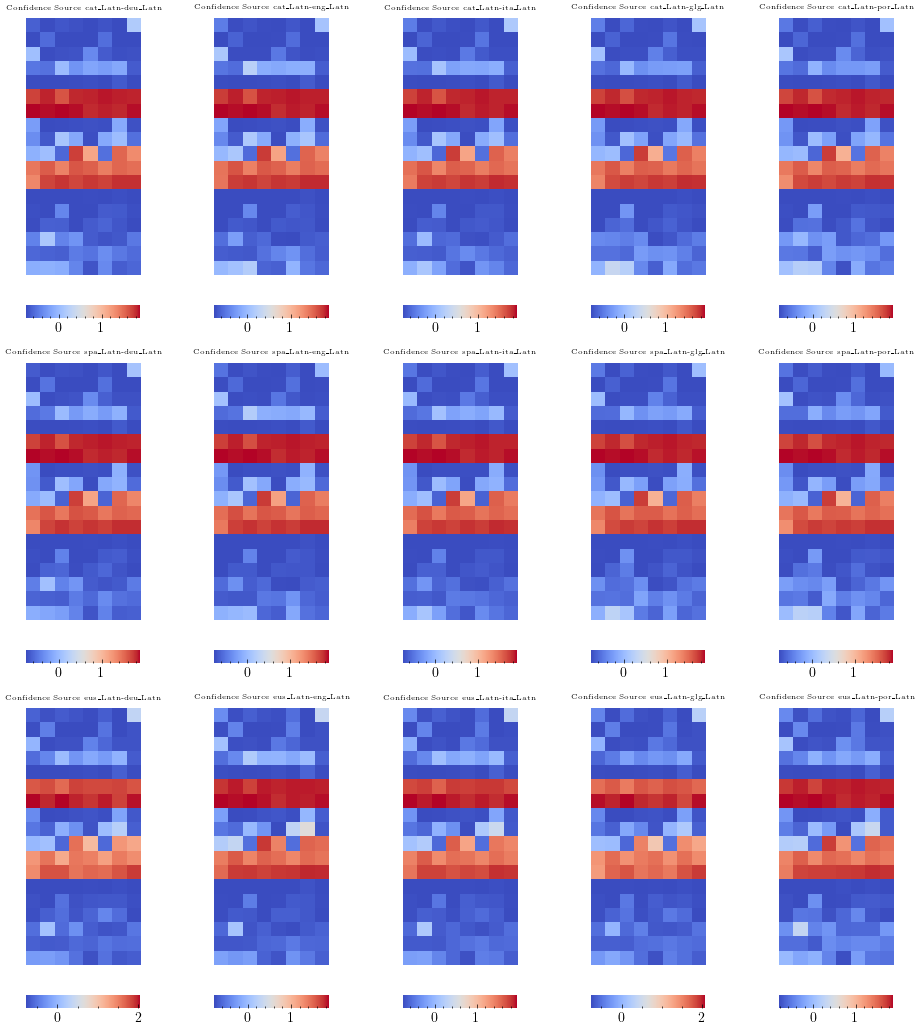

In [ ]:
fig, axes = plt.subplots(nrows=len(language_directions_plot), ncols=len(language_directions_plot[0]), figsize=(FIG_SIZE_WIDTH, FIG_SIZE_HEIGHT_PER_ROW * len(language_directions_plot)))
cax_list = []
for i, lang_directions in enumerate(language_directions_plot):
    for j, lang_direction in enumerate(lang_directions):
        cax = plot_matrix(axes[i, j], lang_direction, coverage_matrices_source, f'Source {lang_direction}')
        if cax:
            cax_list.append(cax)

# Optional: Add a colorbar if needed
#if cax_list:
#    fig.colorbar(cax_list[-1], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02)

plt.tight_layout()
plt.savefig('coverage_source.png', dpi=300)
plt.show()

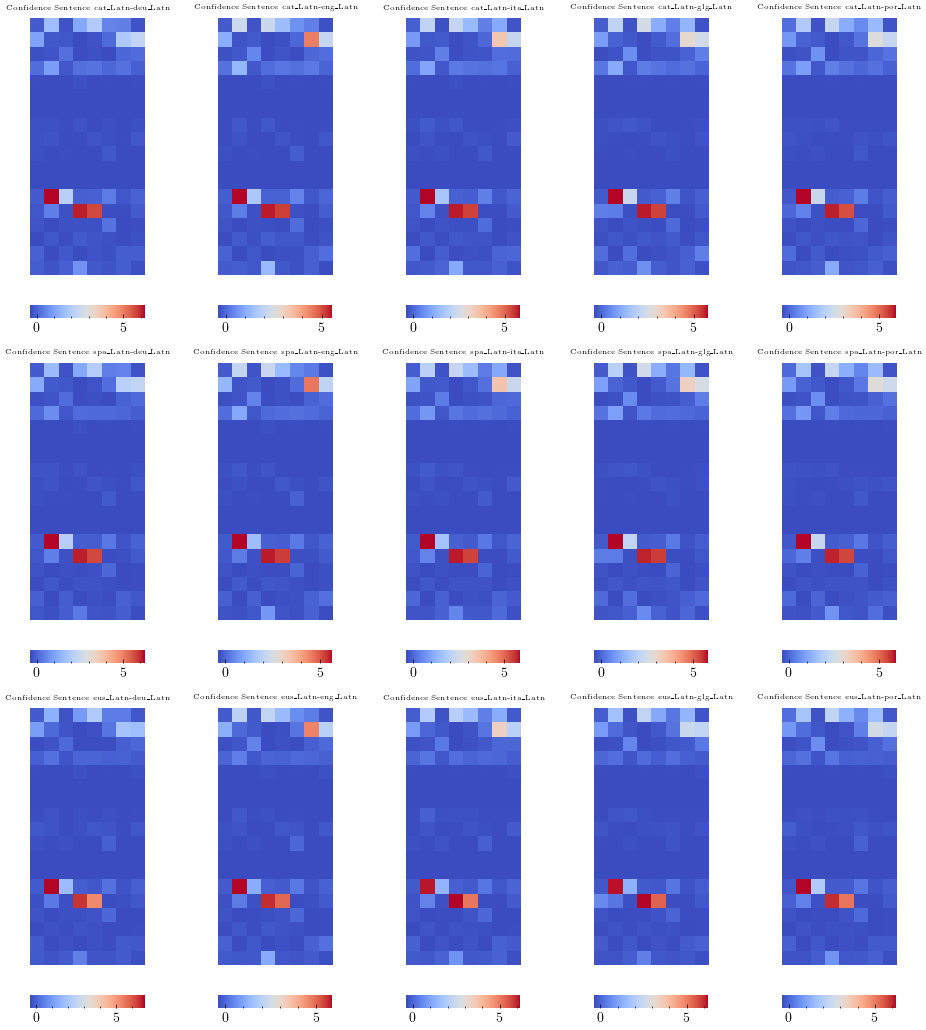

In [ ]:
# Iterate through the data and plot
fig, axes = plt.subplots(nrows=len(language_directions_plot), ncols=len(language_directions_plot[0]), figsize=(FIG_SIZE_WIDTH, FIG_SIZE_HEIGHT_PER_ROW * len(language_directions_plot)))
cax_list = []
for i, lang_directions in enumerate(language_directions_plot):
    for j, lang_direction in enumerate(lang_directions):
        cax = plot_matrix(axes[i, j], lang_direction, coverage_matrices_target, f'Target {lang_direction}')
        if cax:
            cax_list.append(cax)

# Optional: Add a colorbar if needed
#if cax_list:
#    fig.colorbar(cax_list[-1], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02)

plt.tight_layout()
plt.savefig('coverage_target.png', dpi=300)
plt.show()

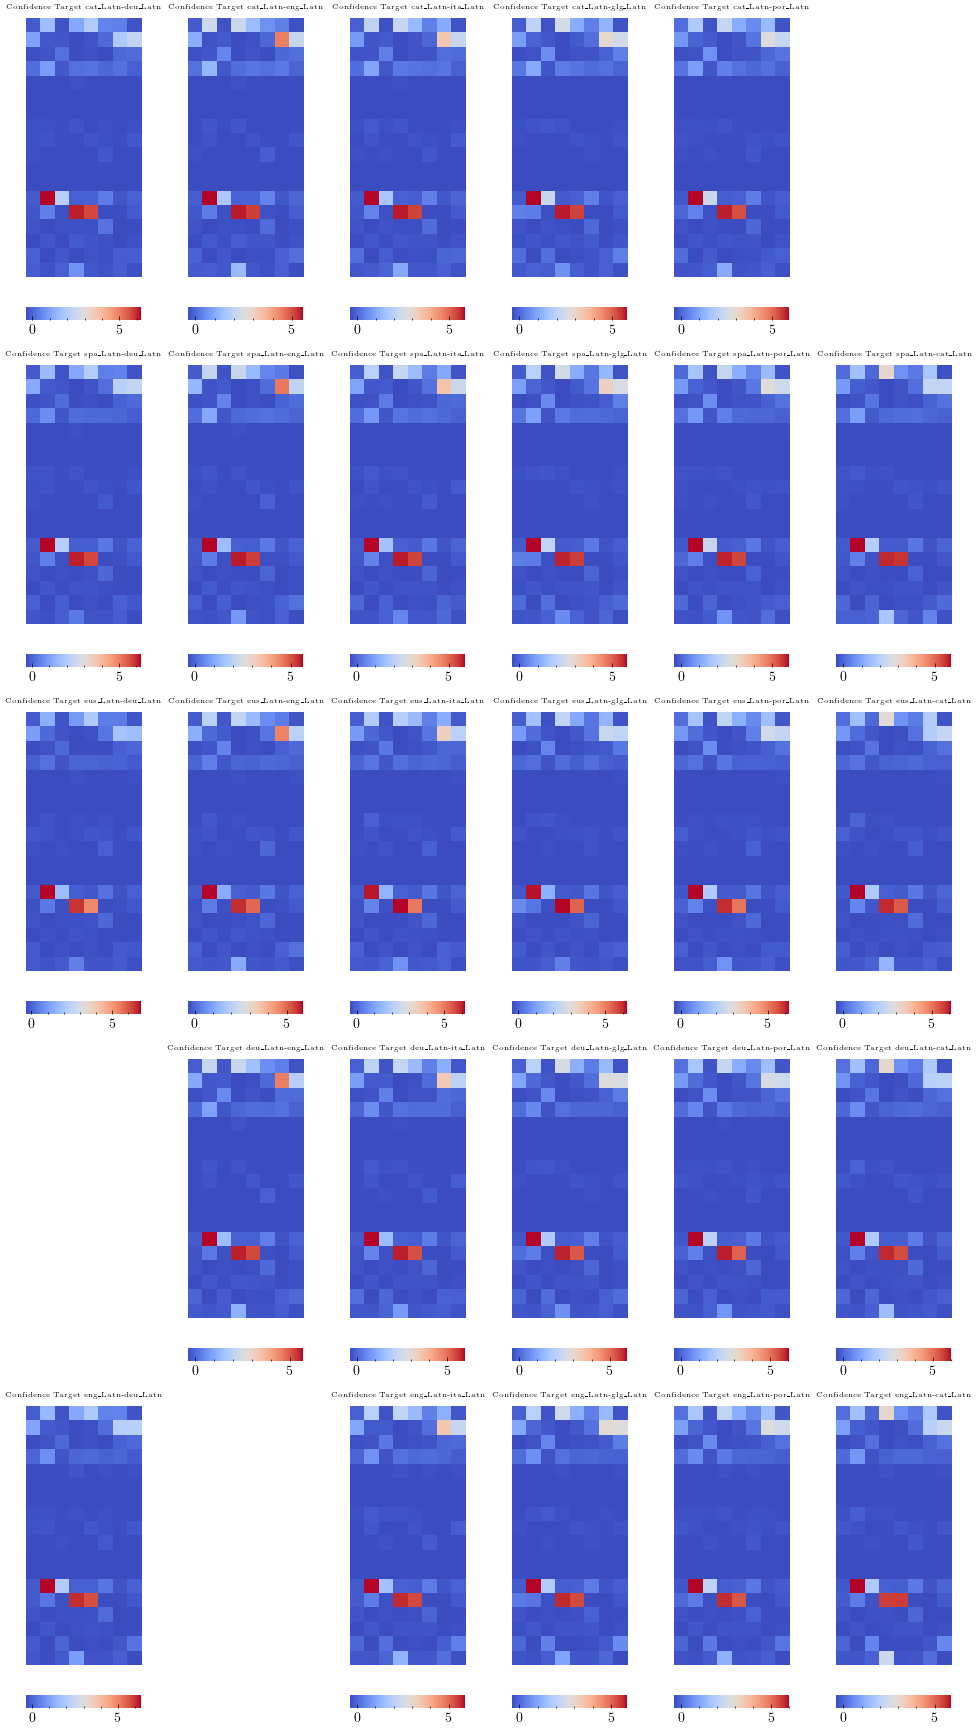

In [ ]:
language_directions_plot = [
    ('cat_Latn-deu_Latn', 'cat_Latn-eng_Latn', 'cat_Latn-ita_Latn', 'cat_Latn-glg_Latn', 'cat_Latn-por_Latn', ''),
    ('spa_Latn-deu_Latn', 'spa_Latn-eng_Latn', 'spa_Latn-ita_Latn', 'spa_Latn-glg_Latn', 'spa_Latn-por_Latn', 'spa_Latn-cat_Latn'),
    ('eus_Latn-deu_Latn', 'eus_Latn-eng_Latn', 'eus_Latn-ita_Latn', 'eus_Latn-glg_Latn', 'eus_Latn-por_Latn', 'eus_Latn-cat_Latn'),
    ('',                  'deu_Latn-eng_Latn', 'deu_Latn-ita_Latn', 'deu_Latn-glg_Latn', 'deu_Latn-por_Latn', 'deu_Latn-cat_Latn'),
    ('eng_Latn-deu_Latn', '',                  'eng_Latn-ita_Latn', 'eng_Latn-glg_Latn', 'eng_Latn-por_Latn', 'eng_Latn-cat_Latn'),
]

fig, axes = plt.subplots(nrows=len(language_directions_plot), ncols=len(language_directions_plot[0]), figsize=(FIG_SIZE_WIDTH, FIG_SIZE_HEIGHT_PER_ROW * len(language_directions_plot)))
cax_list = []
for i, lang_directions in enumerate(language_directions_plot):
    for j, lang_direction in enumerate(lang_directions):
        cax = plot_matrix(axes[i, j], lang_direction, coverage_matrices_target, f'Target {lang_direction}')
        if cax:
            cax_list.append(cax)

# Optional: Add a colorbar if needed
#if cax_list:
#    fig.colorbar(cax_list[-1], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02)

plt.tight_layout()
#plt.savefig('coverage_target.png', dpi=300)
plt.show()

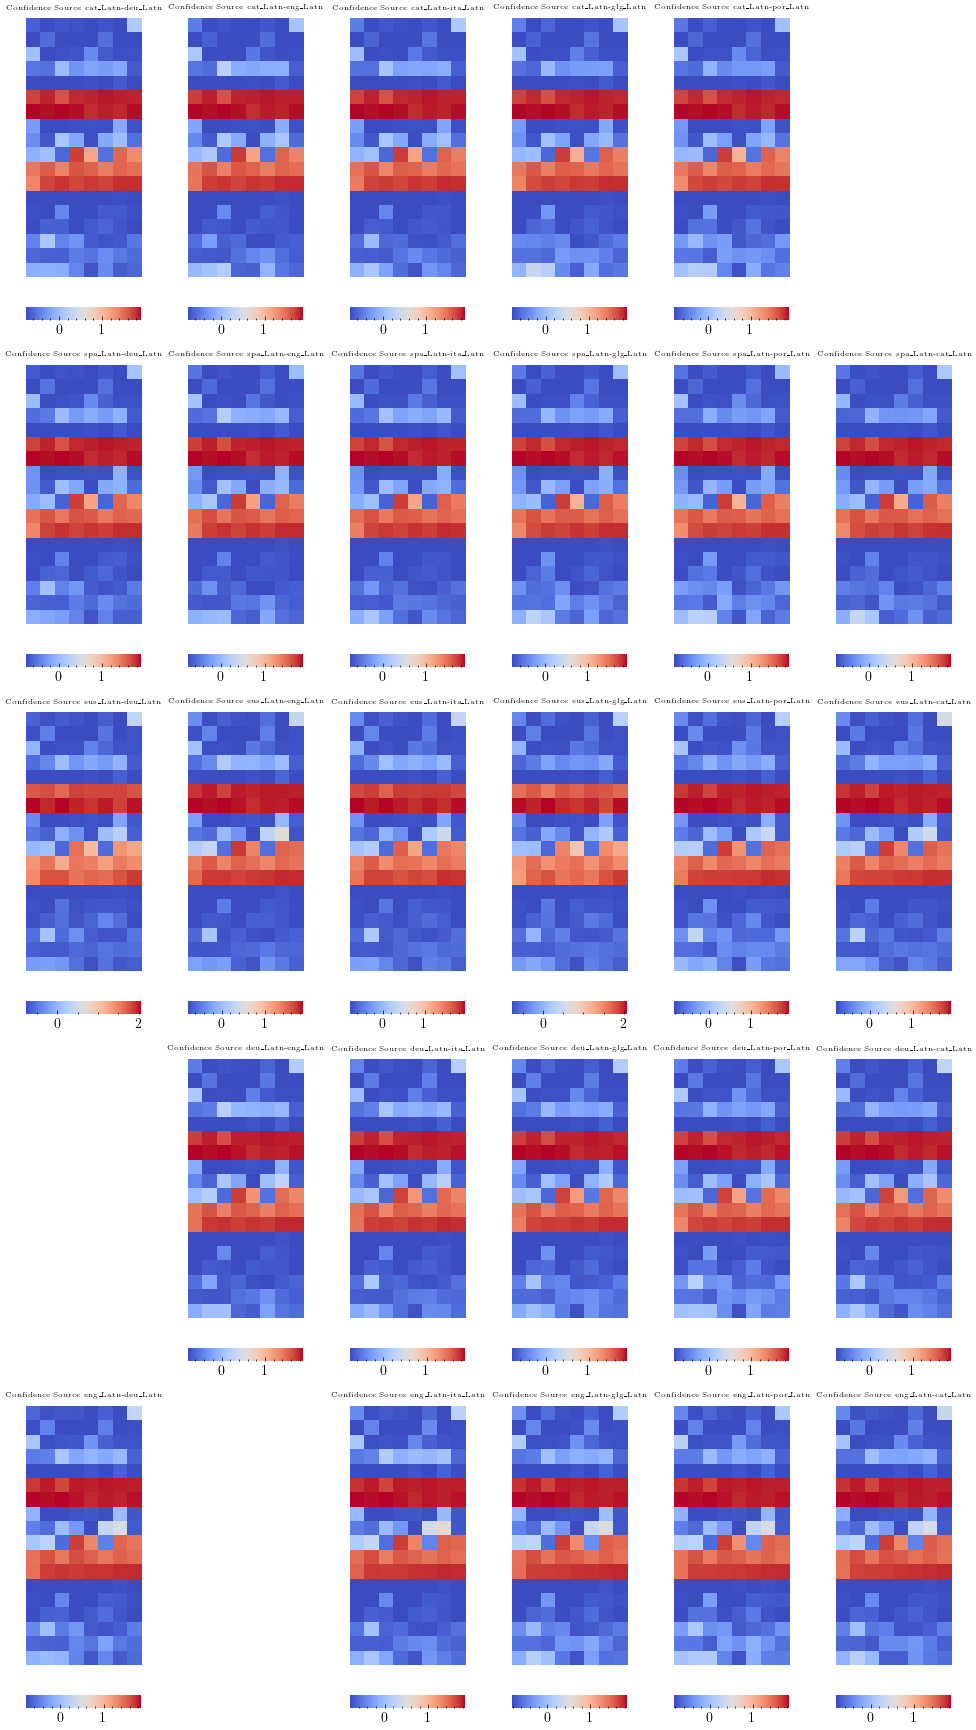

In [ ]:
language_directions_plot = [
    ('cat_Latn-deu_Latn', 'cat_Latn-eng_Latn', 'cat_Latn-ita_Latn', 'cat_Latn-glg_Latn', 'cat_Latn-por_Latn', ''),
    ('spa_Latn-deu_Latn', 'spa_Latn-eng_Latn', 'spa_Latn-ita_Latn', 'spa_Latn-glg_Latn', 'spa_Latn-por_Latn', 'spa_Latn-cat_Latn'),
    ('eus_Latn-deu_Latn', 'eus_Latn-eng_Latn', 'eus_Latn-ita_Latn', 'eus_Latn-glg_Latn', 'eus_Latn-por_Latn', 'eus_Latn-cat_Latn'),
    ('',                  'deu_Latn-eng_Latn', 'deu_Latn-ita_Latn', 'deu_Latn-glg_Latn', 'deu_Latn-por_Latn', 'deu_Latn-cat_Latn'),
    ('eng_Latn-deu_Latn', '',                  'eng_Latn-ita_Latn', 'eng_Latn-glg_Latn', 'eng_Latn-por_Latn', 'eng_Latn-cat_Latn'),
]

fig, axes = plt.subplots(nrows=len(language_directions_plot), ncols=len(language_directions_plot[0]), figsize=(FIG_SIZE_WIDTH, FIG_SIZE_HEIGHT_PER_ROW * len(language_directions_plot)))
cax_list = []
for i, lang_directions in enumerate(language_directions_plot):
    for j, lang_direction in enumerate(lang_directions):
        cax = plot_matrix(axes[i, j], lang_direction, coverage_matrices_source, f'Source {lang_direction}')
        if cax:
            cax_list.append(cax)

# Optional: Add a colorbar if needed
#if cax_list:
#    fig.colorbar(cax_list[-1], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02)

plt.tight_layout()
#plt.savefig('coverage_target.png', dpi=300)
plt.show()